<a href="https://colab.research.google.com/github/Chathura789/food_hygiene-data-pipeline/blob/main/Successful_Map_Extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Selenium
!pip install selenium

In [ ]:
# Update Ubuntu's package list, install Chromium, and make sure the ChromeDriver is in the path
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')


In [ ]:
clubs =["https://www.strava.com/clubs/BCRTSanford/recent_activity?num_entries=20"]

Time stamp Extraction new

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException
import time
import re

def selenium_webdriver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--window-size=1920x1080')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_experimental_option('prefs', {
        "intl.accept_languages": "en_us",
        "enable_do_not_track": True,
    })
    driver = webdriver.Chrome(options=chrome_options)
    return driver

def strava_authentication(strava_login, strava_password):
    driver = selenium_webdriver()
    driver.get('https://www.strava.com/login')
    time.sleep(2)

    try:
        # Dismiss the cookie banner if it exists
        cookie_banner = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, 'stravaCookieBanner'))
        )
        cookie_banner_button = cookie_banner.find_element(By.XPATH, './/button[contains(text(),"Accept")]')
        cookie_banner_button.click()
        time.sleep(2)  # Wait for the banner to be dismissed
    except (NoSuchElementException, TimeoutException):
        pass  # If the banner doesn't appear, move on

    try:
        driver.find_element(By.ID, 'email').send_keys(strava_login)
        driver.find_element(By.ID, 'password').send_keys(strava_password)

        # Attempt to click the login button
        try:
            login_button = driver.find_element(By.ID, 'login-button')
            login_button.click()
        except ElementClickInterceptedException:
            # Handle the case where the button is not clickable due to overlaying elements
            driver.execute_script("arguments[0].click();", login_button)

        time.sleep(5)  # Wait for the login process to complete

    except NoSuchElementException as e:
        print(f"Login elements not found: {e}")

    return driver

def extract_activity_data(driver, urls):
    activities_data = []

    for url in urls:
        driver.get(url)
        time.sleep(5)  # Increased time for dynamic content to load

        try:
            activities = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.XPATH, '//div[@data-testid="web-feed-entry"]'))
            )

            for activity in activities:
                try:
                    athlete_name = activity.find_element(By.XPATH, './/a[contains(@data-testid, "owner-avatar")]').get_attribute('title')
                    activity_name_element = activity.find_element(By.XPATH, './/div[@data-testid="activity_entry_container"]//a')
                    activity_name = activity_name_element.text if activity_name_element else "N/A"
                    distance = activity.find_element(By.XPATH, './/ul/li[1]/div/div').text
                    pace = activity.find_element(By.XPATH, './/ul/li[2]/div/div').text
                    time_spent = activity.find_element(By.XPATH, './/ul/li[3]/div/div').text
                    map_img = activity.find_element(By.XPATH, './/img[contains(@data-testid, "map")]')
                    map_link = map_img.get_attribute('src') if map_img else "N/A"

                    # Extract the feed id from the activity element's id attribute
                    activity_ids = activity.find_elements(By.XPATH, './/div[@data-testid="activity_entry_container"]//h3//a')

                    for activity_id in activity_ids:
                        activity_id = activity_id.get_attribute('href')
                        activity_id = re.sub(pattern=r'^.*/activities/(.*)$', repl=r'\1', string=activity_id, flags=0,)
                        activity_id = re.sub(pattern=r'^([0-9]+)(\?|/|#).*$', repl=r'\1', string=activity_id, flags=0,)
                        break  # Exit after the first match

                    # Extract the date and time of the activity
                    try:
                        date_time = activity.find_element(By.XPATH, '/html/body/div/div[3]/section/div/div/div[1]/div/div/time').get_attribute('datetime')
                    except NoSuchElementException:
                        date_time = "N/A"

                    activities_data.append({
                        'Athlete Name': athlete_name,
                        'Activity Name': activity_name,
                        'Distance': distance,
                        'Pace': pace,
                        'Time': time_spent,
                        'Map Link': map_link,
                        'Source URL': url,  # Including the source URL in the data
                        'Feed ID': activity_id,  # Including the Feed ID in the data
                        'Date Time': date_time  # Including the Date and Time in the data
                    })

                except NoSuchElementException as e:
                    print(f"Some elements could not be found for an activity: {e}")
                    continue

        except TimeoutException as e:
            print(f"Timeout occurred while waiting for activities to load on {url}: {e}")
            continue

    df_activities = pd.DataFrame(activities_data)
    return df_activities

# Credentials (Use environment variables or a safer method in production)
strava_email = 'jsekara@gmail.com'
strava_password = 'aCU3X7QSQ!tjVNp'

driver = strava_authentication(strava_email, strava_password)

# List of URLs to extract data from
urls = clubs

# Extract activity data into a DataFrame
df_activities = extract_activity_data(driver, urls)
print(df_activities)

# Cleanup: close the browser window
driver.quit()


Timeout occurred while waiting for activities to load on https://www.strava.com/clubs/BCRTSanford/recent_activity?num_entries=20: Message: 

Empty DataFrame
Columns: []
Index: []


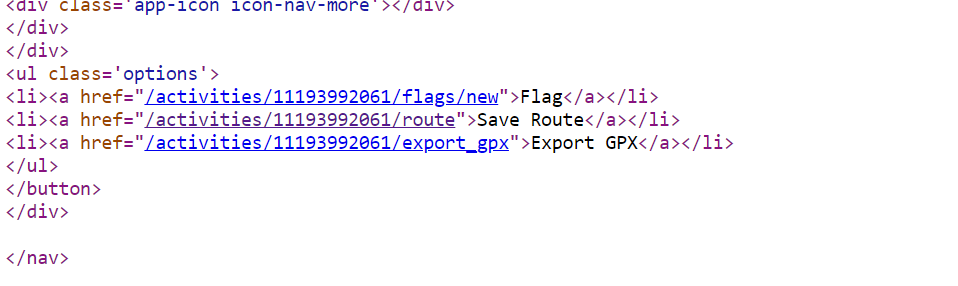

In [ ]:
# CHECK REASONS AND PROOGRESS
# COPy LINK FROM SOURCE  THIS LINK WORKS https://www.strava.com/activities/11193992061/export_gpx



In [ ]:
! pip install strava-tools

In [ ]:
!strava-shell

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from bs4 import BeautifulSoup
import requests


VERSION = '0.1.0'


class StravaScraper(object):
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent
    USER_AGENT = "stravalib-scraper/%s" % VERSION

    HEADERS = {'User-Agent': USER_AGENT}

    BASE_URL = "https://www.strava.com"

    URL_LOGIN = "%s/login" % BASE_URL
    URL_SESSION = "%s/session" % BASE_URL
    URL_DASHBOARD = "%s/dashboard" % BASE_URL

    is_authed = False

    # The content from the /dashboard request post-login (if you'd like to
    # reference it at some point)
    dashboard_content = None

    def __init__(self, email, password):
        self.email = email
        self.password = password
        self.session = requests.Session()

    def get_page(self, url):
        response = self.session.get(url, headers=StravaScraper.HEADERS)
        response.raise_for_status()
        return response

    def login(self):
        response = self.get_page(StravaScraper.URL_LOGIN)
        soup = BeautifulSoup(response.content, 'html.parser')
        utf8 = soup.find_all('input',
                             {'name': 'utf8'})[0].get('value').encode('utf-8')
        token = soup.find_all('input',
                              {'name': 'authenticity_token'})[0].get('value')
        data = {
            'utf8': utf8,
            'authenticity_token': token,
            'plan': "",
            'email': self.email,
            'password': self.password,
        }
        response = self.session.post(StravaScraper.URL_SESSION,
                                     data=data,
                                     headers=StravaScraper.HEADERS)
        response.raise_for_status()
        # Simulate that redirect here:
        response = self.get_page(StravaScraper.URL_DASHBOARD)
        assert("<h2>Activity Feed</h2>" in response.content)
        self.is_authed = True
        # Save this in case someone wants it later...
        self.dashboard_content = response.content


# def main():
#     import sys

#     if len(sys.argv) < 3:
#         print >> sys.stderr, "Usage: ./scraper.py \"<email>\" \"<password>\" [url=\"https://www.strava.com/dashboard\"]"
#         sys.exit(1)
#     email, password = sys.argv[1:3]
#     scraper = StravaScraper(email, password)
#     scraper.login()
#     if len(sys.argv) < 4:
#         # No custom URL to hit, just print the dashboard HTML
#         print scraper.dashboard_content
#         return
#     # You can pass a custom URL to hit, such as:
#     # "https://www.strava.com/challenges/rapha-rising-circle-of-death"
#     url = sys.argv[3]
#     response = scraper.get_page(url)
#     print response.content


# if __name__ == '__main__':
#     main()
scraper.py "jsekara@gmail.com" "aCU3X7QSQ!tjVNp" "https://www.strava.com/clubs/BCRTSanford"

In [ ]:

email = "jsekara@gmail.com"
password = "aCU3X7QSQ!tjVNp"
scraper = StravaScraper(email, password)
scraper.login()
dashboard_html = scraper.dashboard_content
url = "https://www.strava.com/clubs/BCRTSanford"
response = scraper.get_page(url)
rapha_html = response.content

TypeError: a bytes-like object is required, not 'str'